In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, AveragePooling2D
from tensorflow.keras.models import Model


In [53]:
# Define the HRNet architecture
def make_hrnet(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stage 1
    x1 = stage(x, 64, num_blocks=4, stage=1)
    x2 = transition(x1, [256, 512], stage=1)
    x3 = stage(x2, 128, num_blocks=3, stage=1)
    x4 = transition(x3, [256, 512], stage=1)
    
    # Classification Head
    x = AveragePooling2D(pool_size=(7, 7))(x4)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

In [54]:
# Define a single HRNet stage
def stage(input_tensor, num_filters, num_blocks, stage):
    x = input_tensor
    for block in range(1, num_blocks + 1):
        x = bottleneck(x, num_filters, stage, block)
    return x

In [55]:
# Define a bottleneck block
def bottleneck(input_tensor, num_filters, stage, block):
    filters = num_filters * 4
    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Residual connection
    shortcut = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [56]:
# Define a transition layer
def transition(input_tensor, num_filters, stage):
    x = Conv2D(sum(num_filters), (3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    return x

In [58]:
# Define the image size and number of classes
IMAGE_SIZE = (224, 224, 3)  # Adjust the size as needed
NUM_CLASSES = 2

In [61]:
# Create the HRNet model
hrnet_model = make_hrnet(IMAGE_SIZE, NUM_CLASSES)


In [62]:
# Compile the model
hrnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# View the structure of the model
hrnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_59 (Conv2D)          (None, 224, 224, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_59 (Ba  (None, 224, 224, 64)         256       ['conv2d_59[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_24 (Activation)  (None, 224, 224, 64)         0         ['batch_normalization_59

In [63]:
# Train the model
model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)


 70/522 [===>..........................] - ETA: 1:28:27 - loss: 0.3016 - accuracy: 0.8657

In [11]:
# Global Average Pooling Layer
x = GlobalAveragePooling2D()(x)

In [12]:
# Fully Connected Layer for binary classification (adjust units and activation as needed)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [13]:
# Create a model
model = Model(inputs=input_layer, outputs=predictions)


In [14]:
# View the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 224, 224, 64)         0         ['batch_normalization[0][0

In [15]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [16]:
# Create image data generators for the training and validation data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)


In [17]:
# Generate training and validation data
training_set = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=IMAGE_SIZE,
    batch_size=10,
    class_mode='binary'
)

test_set = test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=IMAGE_SIZE,
    batch_size=10,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
# Train the model
model.fit(
    training_set,
    validation_data=test_set,
    epochs=1,  # Adjust the number of epochs as needed
)

522/522 [==============================] - 62428s 120s/step - loss: 0.3545 - accuracy: 0.8464 - val_loss: 0.5436 - val_accuracy: 0.7420


In [43]:
# Evaluate the model
test_set.reset()  # Reset the test_set generator for consistent results
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions


63/63 [==============================] - 101s 2s/step


In [44]:
# Get true labels
true_labels = test_set.classes

In [45]:
# Calculate metrics
accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred)
recall = recall_score(true_labels, y_pred)
f1 = f1_score(true_labels, y_pred)

Accuracy: 56.57%
Precision: 0.62
Recall: 0.82
F1 Score: 0.70


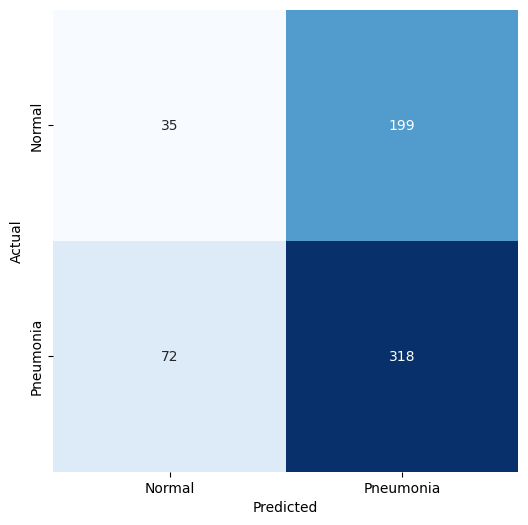

In [46]:
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

# Create and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
# Load and preprocess an image for prediction
from keras.preprocessing import image
img = image.load_img('chest_xray/test/Normal/IM-0001-0001.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
result = int(classes[0][0])

if result == 0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")


1/1 [==============================] - 0s 412ms/step
Person is Affected By PNEUMONIA


In [30]:
# Initialize an empty list to store true and predicted labels
true_labels = []
predicted_labels = []

In [39]:
# Initialize Python lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through the test set and predict labels
for i in range(len(test_set)):
    batch = test_set[i]
    images, labels = batch
    predictions = model.predict(images)

    # Convert one-hot encoded labels to class labels
    true_labels.append(np.argmax(labels, axis=0))
    predicted_labels.append(np.argmax(predictions, axis=0))


1/1 [==============================] - 1s 523ms/step


([<matplotlib.axis.YTick at 0x1703bf090>,
 [Text(0, 0, 'Normal'), Text(0, 1, 'PNEUMONIA')])

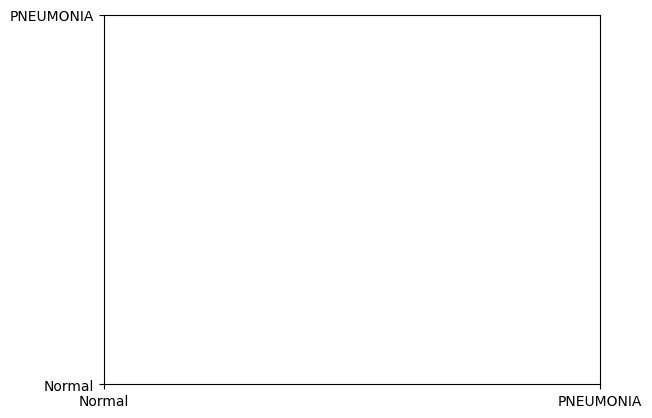

In [41]:
class_labels = ['Normal', 'PNEUMONIA']
plt.xticks(range(len(class_labels)), class_labels)
plt.yticks(range(len(class_labels)), class_labels)


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (2).

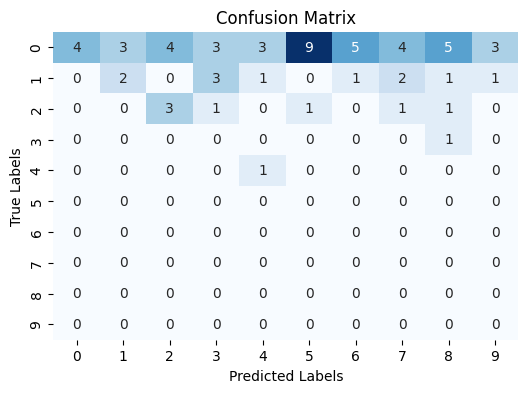

In [42]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])  # Modify class labels accordingly
plt.yticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])  # Modify class labels accordingly
plt.show()


In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy   :", accuracy)
precision = precision_score(true_labels, predicted_labels)
print("Precision :", precision)
recall = recall_score(true_labels, predicted_labels)
print("Recall    :", recall)
F1_score = f1_score(true_labels, predicted_labels)
print("F1-score  :", F1_score)

Accuracy   : 0.8477564102564102
Precision : 0.8105263157894737
Recall    : 0.9871794871794872
F1-score  : 0.8901734104046243


In [32]:
# Make predictions on the test set
predictions = model.predict(test_set)
predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]  # Assuming a threshold of 0.5


63/63 [==============================] - 85s 1s/step


In [33]:
# Extract the true labels from the test set
true_labels = test_set.classes


In [34]:
# Calculate and print the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[ 39 195]
 [ 68 322]]


In [35]:
# Calculate various evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 57.85%
Precision: 62.28%
Recall: 82.56%
F1 Score: 0.71


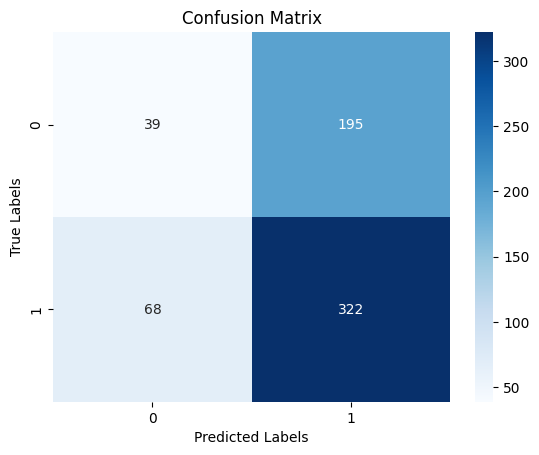

In [36]:
# You can also visualize the confusion matrix using a heatmap
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()